In [21]:
from bs4 import BeautifulSoup as bs #import libraries needed
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist


In [2]:
url='https://en.wikipedia.org/wiki/Districts_of_Hong_Kong'
response = requests.get(url)
soup = bs(response.text, 'html.parser')
table = soup.find('table',{'class':'wikitable sortable'}).tbody #grab the table content
rows = table.find_all('tr') #identify the rows
columns = [v.text.replace('\n','') for v in rows[0].find_all('th')]#indentify the columns' name from the first row
df=pd.DataFrame(columns=columns) #produce the dataframe from pandas
for i in range(1, len(rows)): #read the contents of each row
    tds = rows[i].find_all('td')
    if len(tds) ==4:
        values = [tds[0].text, tds[1].text,tds[2].text.replace('\n','')]
    else:
        values = [td.text .replace('\n','') for td in tds]
    df = df.append(pd.Series(values, index = columns), ignore_index = True)#insert the values into the data frame

In [3]:
df=df.drop(['Chinese','Population [6]','Area(km²)','Density(/km²)','Region'],axis=1) #drop irrelevant columns 

In [4]:
df.head(1) #show the first row

,District
0,Central and Western


In [6]:
a=[]
b=[]
for i in range(df.shape[0]):
    address = (str(df['District'][i])+', Hong Kong, China')
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    a.append(latitude)
    b.append(longitude)
a[1]= 22.279594
a[2]= 22.247692
a[9]= 22.289997
a[11]= 22.497353
b[1]= 114.232420
b[2]= 114.154762
b[9]= 113.943162
b[11]= 114.132719
df['latitude']=a
df['longitude']=b
#import the location of districts

In [7]:
df #show table

,District,latitude,longitude
0,Central and Western,22.285239,114.150679
1,Eastern,22.279594,114.232420
2,Southern,22.247692,114.154762
3,Wan Chai,22.277465,114.173026
4,Sham Shui Po,22.330095,114.160940
5,Kowloon City,22.331013,114.190366
6,Kwun Tong,22.312126,114.226501
7,Wong Tai Sin,22.342063,114.194388
8,Yau Tsim Mong,22.307453,114.165202
9,Islands,22.289997,113.943162


In [8]:
address = 'Hong Kong, China'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #find hong kong location
HK_latitude = location.latitude
HK_longitude = location.longitude

map_HongKong = folium.Map(location=[HK_latitude+0.1, HK_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, dis in zip(df['latitude'], df['longitude'], df['District']):
    label = folium.Popup(str(dis), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_HongKong)
       
map_HongKong #show map in hong kong with 18 district spots

In [9]:
CLIENT_ID='STAAEV31ZRBNPJ5IARPEX5DMXL5R5JLG4PZLKUOPQPIUG0WU'
CLIENT_SECRET='ZLFKSFKOLYII3HL4OKMZV30RFURJ3PZGJNSTDPWXITLF3NZQ'
VERSION='20181201'
LIMIT = 1000
radius=1000
def getNearbyVenues(names, latitudes, longitudes): #def a function to get venues of each districts within 1000m
    venues_list=[]

    for dis, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']


        venues_list.append([(
            dis, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)



In [10]:
HK_venues = getNearbyVenues(names=df['District'], #create a new table of venues in each district
                                latitudes=df['latitude'],
                                longitudes=df['longitude']
                                )

In [11]:
HK_venues.groupby('District').count() #count the venues no. in each district

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Central and Western,100,100,100,100,100,100
Eastern,40,40,40,40,40,40
Islands,45,45,45,45,45,45
Kowloon City,82,82,82,82,82,82
Kwai Tsing,14,14,14,14,14,14
Kwun Tong,89,89,89,89,89,89
North,18,18,18,18,18,18
Sai Kung,60,60,60,60,60,60
Sha Tin,90,90,90,90,90,90


In [12]:
# one hot encoding
HK_onehot = pd.get_dummies(HK_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
HK_onehot['District'] = HK_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [HK_onehot.columns[-1]] + list(HK_onehot.columns[:-1])
HK_onehot = HK_onehot[fixed_columns]
HK_grouped = HK_onehot.groupby('District').mean().reset_index() 

In [13]:
num_top_venues = 5

for hood in HK_grouped['District']: #calculate the frequency of each type of venue in each district, sorted descending
    print("----"+hood+"----")
    temp = HK_grouped[HK_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n') 

----Central and Western----
                 venue  freq
0                 Café  0.09
1  Japanese Restaurant  0.06
2   Chinese Restaurant  0.05
3          Coffee Shop  0.05
4   Italian Restaurant  0.04


----Eastern----
                  venue  freq
0  Fast Food Restaurant  0.10
1          Noodle House  0.10
2          Dessert Shop  0.05
3                  Park  0.05
4      Asian Restaurant  0.05


----Islands----
                 venue  freq
0          Coffee Shop  0.09
1    Accessories Store  0.04
2  Sporting Goods Shop  0.04
3   Chinese Restaurant  0.04
4       Clothing Store  0.04


----Kowloon City----
                venue  freq
0     Thai Restaurant  0.15
1        Dessert Shop  0.12
2  Chinese Restaurant  0.09
3         Coffee Shop  0.06
4                Café  0.05


----Kwai Tsing----
                  venue  freq
0                 Hotel  0.21
1         Grocery Store  0.14
2  Fast Food Restaurant  0.14
3     Convenience Store  0.14
4                Tunnel  0.14


----Kwun Tong-

In [14]:
def return_most_common_venues(row, num_top_venues): #fill only the venues with high frequency
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
HK_venues_sorted = pd.DataFrame(columns=columns)
HK_venues_sorted['District'] = HK_grouped['District']

for ind in np.arange(HK_grouped.shape[0]):
    HK_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HK_grouped.iloc[ind, :], num_top_venues)

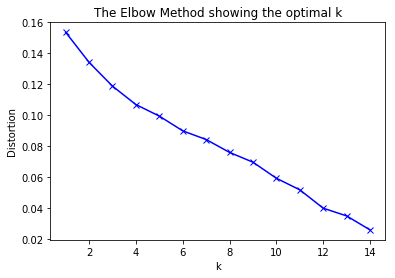

In [24]:
distortions = []
K = range(1,15) #set the range of K for test
HK_grouped_clustering = HK_grouped.drop('District', 1)
for k in K: #calculate the distortion for each K 
    kmeanModel = KMeans(n_clusters=k).fit(HK_grouped_clustering)
    kmeanModel.fit(HK_grouped_clustering)
    distortions.append(sum(np.min(cdist(HK_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / HK_grouped_clustering.shape[0])

plt.plot(K, distortions, 'bx-')#plot the distortion for each K
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [25]:
kclusters = 4 #set the K as the optimal K

HK_grouped_clustering = HK_grouped.drop('District', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(HK_grouped_clustering)

kmeans.labels_[0:10]

array([0, 3, 0, 0, 2, 3, 1, 0, 0, 3], dtype=int32)

In [26]:
HK_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)#insert the cluster labels for each district

HK_merged=df

HK_merged = HK_merged.join(HK_venues_sorted.set_index('District'), on='District')


In [28]:
# create map
map_clusters = folium.Map(location=[HK_latitude, HK_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, dis, cluster in zip(HK_merged['latitude'], HK_merged['longitude'], HK_merged['District'], HK_merged['Cluster Labels']):
    label = folium.Popup(str(dis) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
HK_merged

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,22.285239,114.150679,0,Café,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Italian Restaurant,French Restaurant,Cocktail Bar,Vegetarian / Vegan Restaurant,Indian Restaurant,Salad Place
1,Eastern,22.279594,114.232420,3,Fast Food Restaurant,Noodle House,Dessert Shop,Dumpling Restaurant,Convenience Store,Hong Kong Restaurant,Asian Restaurant,Park,Chinese Restaurant,Cha Chaan Teng
2,Southern,22.247692,114.154762,3,Chinese Restaurant,Fast Food Restaurant,Shopping Mall,Hotel,Furniture / Home Store,Seafood Restaurant,Park,Hong Kong Restaurant,Sushi Restaurant,Clothing Store
3,Wan Chai,22.277465,114.173026,0,Hotel,Chinese Restaurant,Café,Coffee Shop,Cantonese Restaurant,Hong Kong Restaurant,Steakhouse,Dim Sum Restaurant,Thai Restaurant,Spanish Restaurant
4,Sham Shui Po,22.330095,114.160940,3,Noodle House,Chinese Restaurant,Fast Food Restaurant,Hong Kong Restaurant,Shopping Mall,Café,Dessert Shop,Dumpling Restaurant,Hotpot Restaurant,Coffee Shop
5,Kowloon City,22.331013,114.190366,0,Thai Restaurant,Dessert Shop,Chinese Restaurant,Coffee Shop,Café,Noodle House,Fast Food Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Department Store
6,Kwun Tong,22.312126,114.226501,3,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Café,Hong Kong Restaurant,Japanese Restaurant,Cha Chaan Teng,Department Store,Sushi Restaurant,Shopping Mall
7,Wong Tai Sin,22.342063,114.194388,3,Chinese Restaurant,Fast Food Restaurant,Shopping Mall,Coffee Shop,Hong Kong Restaurant,Noodle House,Park,Asian Restaurant,Athletics & Sports,Clothing Store
8,Yau Tsim Mong,22.307453,114.165202,0,Hotel,Chinese Restaurant,Dessert Shop,Noodle House,Café,Coffee Shop,Dim Sum Restaurant,Seafood Restaurant,Indian Restaurant,Cha Chaan Teng
9,Islands,22.289997,113.943162,0,Coffee Shop,Accessories Store,Café,Sushi Restaurant,Fast Food Restaurant,Clothing Store,Chinese Restaurant,Sporting Goods Shop,Cantonese Restaurant,Cha Chaan Teng
